In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.spatial import distance_matrix

<h1 align="center"><b><u>Lecture 8 - Hilbert Spaces</u></b></h1>

<h2>Reproducing Kernel Hilbert Space</h2>

Lecture 8 introduces the idea of function approximation through the use of Reproducing Kernel Hilbert Space (RKHS).  This example reflects the regularised empirical error minimisation problem seen at the end of the lecture.  The derivations are shown here for a general kernel, and then the example is evaluated using a Gaussian kernel function.<br/>

The dataset is made from pairs of 1D inputs and outputs $(x_1,y_1), (x_2,y_2), ... ,(x_N,y_N) \in \mathcal{X} \times \mathbb{R}$<br/> 

The regularised empirical error is given by:
$$
\frac{1}{N} \sum_{i=1}^{N} | f(x_i) - y_i |^2 + \lambda \left\Vert f \right\Vert^2
$$

and is minimised by functions of the form:

$$
\hat{f}(\cdot) = \sum_{n=1}^{N} \alpha_n k(\cdot, x_n)
$$

Where $k(\cdot,\cdot)$ is a general reproducing kernel function.  The coefficients can be found by evaluating:

$$
\underset{\alpha \in \mathbb{R}^N}{\mathrm{argmin}} \frac{1}{N} \sum_{i=1}^{N} | f(x_i) - y_i |^2 + \lambda \left\Vert f \right\Vert^2
$$

Defining the following vectors and matrix allows the error to be defined in vector form:

$$
\alpha = 
\begin{bmatrix}
\alpha_1\\
\alpha_2\\
\vdots\\
\alpha_N\\
\end{bmatrix}
\text{    ,    }
y = 
\begin{bmatrix}
y_1\\
y_2\\
\vdots\\
y_N\\
\end{bmatrix}
\text{    ,    }
K_{ij} = k(x_i,x_j)
$$

$$
\alpha^* = \underset{\alpha \in \mathbb{R}^N}{\mathrm{argmin}}\frac{1}{N}  
(K\alpha-y)^T(K\alpha-y) + \lambda \left\Vert f \right\Vert^2
$$

The error here is convex, and so the solution for alpha is found by taking the derivative and setting to zero. First the $L_2$ norm of $f$ needs to be rewritten.<br/>

$$
\left\Vert f \right\Vert^2 = \langle f,f \rangle = \sum_{i}\sum_{j} \alpha_i\alpha_j
\langle k(\cdot,x_i),k(\cdot,x_j) \rangle = \sum_{i}\sum_{j} \alpha_i\alpha_j k(x_i,x_j) = 
\alpha^T K \alpha
$$

The third equality here is the significant step, and uses the reproducing property of the kernel function. i.e. $f = \langle f, k \rangle$.

$$
\frac{\partial}{\partial \alpha} \frac{1}{N}  
(K\alpha-y)^T(K\alpha-y) + \lambda \alpha^T K \alpha = 0 
$$
$$
\frac{1}{N}K (K\alpha - y) + \lambda K \alpha = 0
$$

The linear system that must then be solved is given below, this step is legitimate since $K$ must be positive semi-definite (positive definite if there are no repeated $x_i$ in the dataset).

$$
(K + \lambda N I )\alpha = y
$$


The dataset for the example will be generated using a generating function, with some small amount of noise so that the final approximating function can be compared to the generating function to see how good the approximation is.

In [33]:
###--- Data generation ---###
sigma = 0.1    # The small added noise
N = 10         # Number of training points

# Generate data with some small error - uncomment the desired function
g = lambda x: 2*x + np.sin(10*x) + 2      # Sine wave - l=0.1 works well, smaller length scale
#g = lambda x: x                          # Ramp function - l=1 works well, larger length scale

The generating function is defined as:

$$
g(x) = \sin\left(10x\right) + 2x + 2
$$

and is evaluated at the training points $\{x_i\}_{i=1}^{N}$, giving $\{y_i\}_{i=1}^{N}$, with added noise to generate the data.  For plotting and further inspection of the function, it is also evaluated  at $\{d_j\}_{j=1}^{J}$, the evaluation points, with $J>>N$.


In [34]:
# Training points
x = np.linspace(0,1,N)
y = g(x) + norm.rvs(size=N, loc=0,scale=sigma)

# Evaluation points
d = np.linspace(0,1,100)

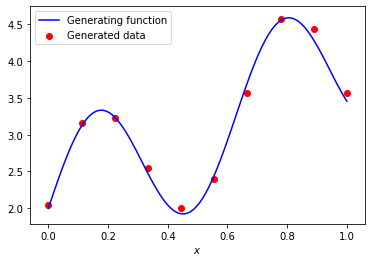

In [35]:
## Ploting
plt.plot(d,g(d),color='b',label="Generating function")
plt.scatter(x,y,color='r',label="Generated data")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

The Gaussian kernel must now be defined, parameterised with a length scale parameter $l$.  The form of the Gaussian kernel is defined below:

$$
k(x,y) = \exp\left(-\frac{|y-x|^2}{2l^2}\right)
$$

For the implementation, the $\texttt{scipy.spatial.distance-matrix}$ function is used to generate a matrix from the training point locations $x$, this is then scaled by $\frac{-1}{2l^2}$ an fed through the $\texttt{np.exp}$ function which performs the element wise exponential, finally giving $K_{xx}$ - the kernel matrix generated by the training point locations $x$.  This is an efficient vectorised procedure for evaluating the kernel matrix.


In [36]:
def GaussianKernel(x_data, l):
    """ Generate Gaussian kernel matrix efficiently using scipy's distance matrix function"""
    x = x_data.reshape((len(x_data), 1))
    Y = distance_matrix(x,x)
    return np.exp(-pow(Y,2)/(2*pow(l,2)))

The next step is to solve the linear systems equation $(K\alpha + \lambda N I ) = y$, which  is done using $\texttt{np.linalg.lstsq}$, a least sqaures approach for evaluating the inverse.

In [37]:
def solve(K, x_data, y_data, reg):
    return np.linalg.lstsq((K + (reg*len(x_data)*np.eye(len(x_data)))), y_data, rcond=None)[0]

The last function approximates the function using the dataset and the evaluation points, so that we can compare the approximating function to the original generating function over the space.

Each evaluation point gives an approximation:

$$
\hat{f}(d_j) = \sum_{n=1}^{N} \alpha_n k(d_j, x_n)
$$

or vectorised:

$$
\hat{f}_{d} =   K_{dx} \alpha
$$

where $K_{dx}$ is generated from the vectors $d$ and $x$

In [38]:
def approximate(x_new, l, alpha, x_data):
    # get input data into (N,1) shape
    x_data = x_data.reshape((len(x_data), 1))
    x_new = x_new.reshape((len(x_new), 1))
    
    # Get kernel matrix
    Y = distance_matrix(x_data, x_new)
    Kxd = np.exp(-pow(Y.T, 2) / (2 * pow(l, 2)))
    
    # Perform approximation (equivalent to vectorised version of above markdown equation)
    y_new = Kxd @ alpha

    return y_new

In [45]:
###--- Parameters ---###
lam = 0.01   # Regularisation constant
l = 0.1     # Gaussian kernel length scale

In [46]:
K = GaussianKernel(x,l)                   # Generate Gaussian kernel

alpha = solve(K,x,y,lam)                  # Solve equations for the coefficients

y_approx = approximate(d,l,alpha,x)       # Evaluate the approximating function given the coefficients

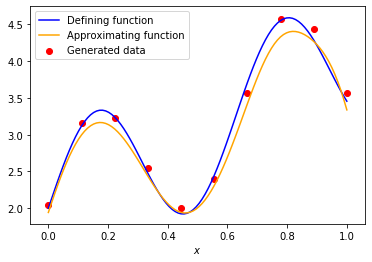

In [47]:
## Plotting
plt.plot(d,g(d),color='b',label="Defining function")
plt.scatter(x,y,color='r',label="Generated data")
plt.plot(d,y_approx,color='orange',label="Approximating function")
plt.xlabel(r"$x$")
plt.legend()
plt.show()

Now adjust both the generating function $g$, and the parameters ($lam$ and $l$).

Try:
<ul>
    <li>Changing the generating function to the ramp function $g(x) = x$ with $l=0.1$.</li>
    <li>Now increase $l$ to 1, does the approximation improve? why?</li>
    <li>Now go back to the original generating function, with $l=0.1$, $lam=0.01$.  Adjust $lam$ between $0.001 - 10$ and observe the fit.  what is $\lambda$ doing?</li>
    <li>Adjust $l$ between 0.001 and 1, when is the approximation the best?  how does this relate to $g(x)$?</li>
</ul>

